In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Try find corner of chessboard by color mask and morphological operation

In [2]:
# img = cv2.imread(r'..\img_test\frame_game_fixed.png')
img = cv2.imread(r'..\img_test\frame_fix_clean.jpg')

# convert the image to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
def color_mask(image, lower_rgb, upper_rgb):
    lower_bound = np.array(lower_rgb, dtype=np.uint8)
    upper_bound = np.array(upper_rgb, dtype=np.uint8)
    mask = cv2.inRange(image, lower_bound, upper_bound)
    return mask

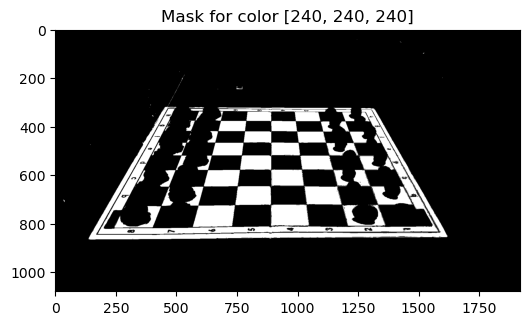

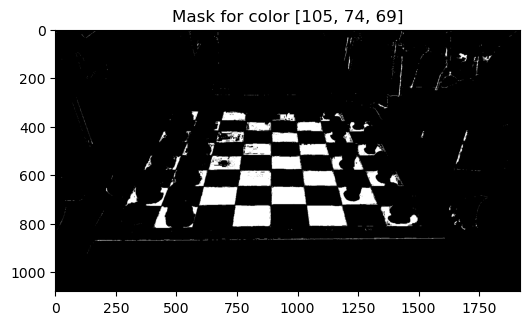

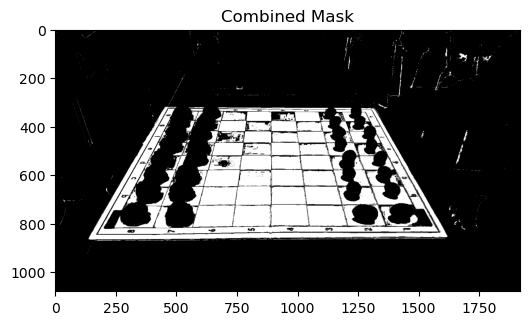

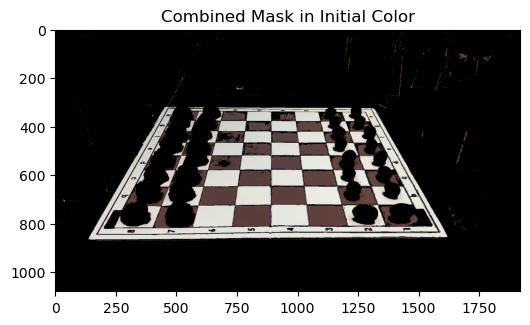

In [4]:
# define RGB color ranges for the two chessboard colors
white = [235, 236, 228]  
black = [95, 64, 59]

pink = [255, 59, 155]  
blue = [44, 163, 227]   

# could be used to detect colored stickers
# white = pink
# black = blue

range_white = 45         
range_black = 10         
lower_white = [max(0, c - range_white) for c in white]
upper_white = [min(240, c + range_white) for c in white] 
lower_black = [max(0, c - range_black) for c in black] 
upper_black = [min(240, c + range_black) for c in black] 

# create masks for both the white and black squares of the chessboard
mask_white = color_mask(img_rgb, lower_white, upper_white)
plt.figure(figsize=(6, 6))
plt.title(f"Mask for color {upper_white}")
plt.imshow(mask_white, cmap='gray')
plt.show()

mask_black = color_mask(img_rgb, lower_black, upper_black)
plt.figure(figsize=(6, 6))
plt.title(f"Mask for color {upper_black}")
plt.imshow(mask_black, cmap='gray')
plt.show()

# combine the masks to isolate the chessboard
combined_mask = cv2.bitwise_or(mask_white, mask_black)
plt.figure(figsize=(6, 6))
plt.title("Combined Mask")
plt.imshow(combined_mask, cmap='gray')
plt.show()

# convert the combined mask back to the initial color
initial_color_mask = cv2.bitwise_and(img_rgb, img_rgb, mask=combined_mask)
plt.figure(figsize=(6, 6))
plt.title("Combined Mask in Initial Color")
plt.imshow(initial_color_mask)
plt.show()

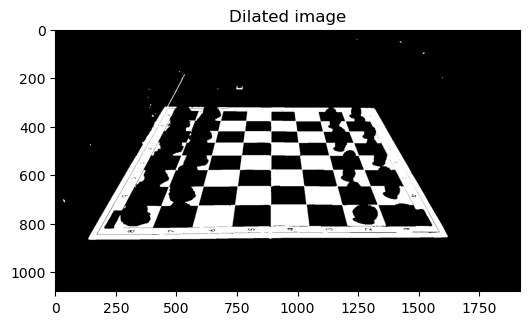

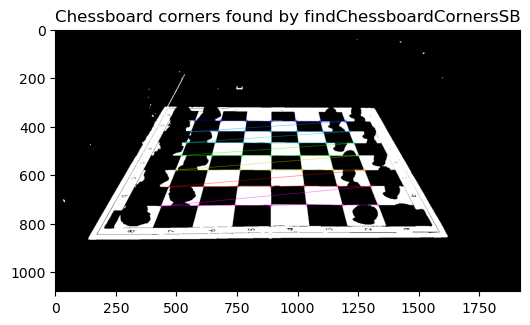

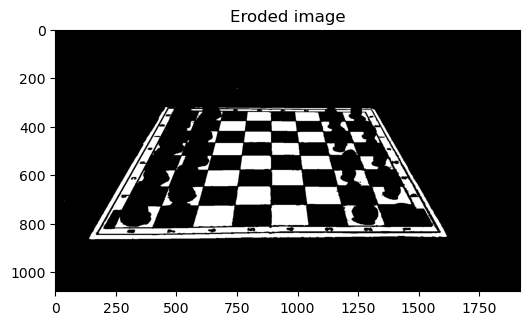

Chessboard not found


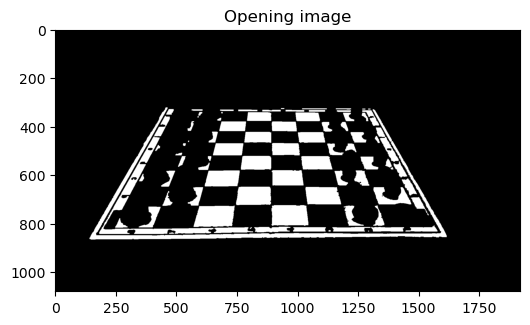

Chessboard not found


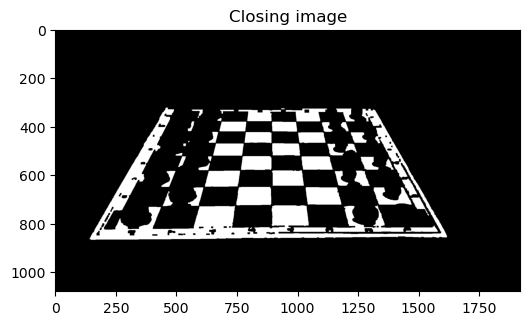

Chessboard not found


In [5]:
object_points_all = []  # 3D points in real-world space
image_points_all = []   # 2D points in image space

def chess_corner(img):
    chessboard_size = (7, 7)
    object_points_template = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    object_points_template[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

    ret, corners = cv2.findChessboardCornersSB(img, chessboard_size,
                                              cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FILTER_QUADS + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK)
    if ret:# Refine corner locations
        corners = cv2.cornerSubPix(img, corners, (11, 11), (-1, -1),
                                  criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1))
        
        object_points_all.append(object_points_template)
        image_points_all.append(corners)
        img_corners = cv2.drawChessboardCorners(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), chessboard_size, corners, ret)
        plt.figure(figsize=(6, 6))
        plt.title("Chessboard corners found by findChessboardCornersSB")
        plt.imshow(img_corners)
        plt.show()
    else:
        print("Chessboard not found")

def dilate(img, kernel_size, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img_dilate = cv2.dilate(img, kernel, iterations=iterations)
    plt.figure(figsize=(6, 6))
    plt.title("Dilated image")
    plt.imshow(img_dilate, cmap='gray')
    plt.show()
    return img_dilate

def erode(img, kernel_size, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img_erode = cv2.erode(img, kernel, iterations=iterations)
    plt.figure(figsize=(6, 6))
    plt.title("Eroded image")
    plt.imshow(img_erode, cmap='gray')
    plt.show()
    return img_erode

def opening(img, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img_opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    plt.figure(figsize=(6, 6))
    plt.title("Opening image")
    plt.imshow(img_opening, cmap='gray')
    plt.show()
    return img_opening

def closing(img, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    img_closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    plt.figure(figsize=(6, 6))
    plt.title("Closing image")
    plt.imshow(img_closing, cmap='gray')
    plt.show()
    return img_closing

# use white_mask since capture better the chessboard
combined_mask = mask_white

combined_mask_morph = combined_mask.copy()

# Perform some morphological operations

combined_mask_dilate = dilate(combined_mask_morph, 3)
## OK great, now we have a mask that isolates the chessboard
chess_corner(combined_mask_dilate)

# opening = erosion followed by dilation
combined_mask_opening = erode(combined_mask_morph, 3)
chess_corner(combined_mask_opening)

combined_mask_opening = opening(combined_mask_opening, 4)
chess_corner(combined_mask_opening)

# closing = dilation followed by erosion
combined_mask_closing = closing(combined_mask_opening, 6)
chess_corner(combined_mask_closing)

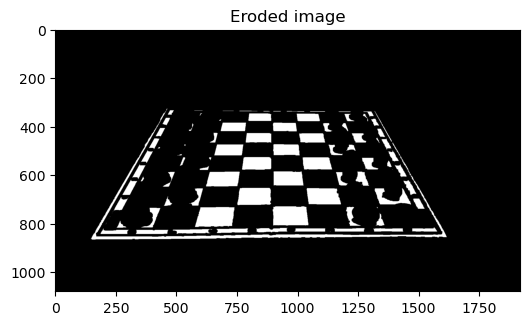

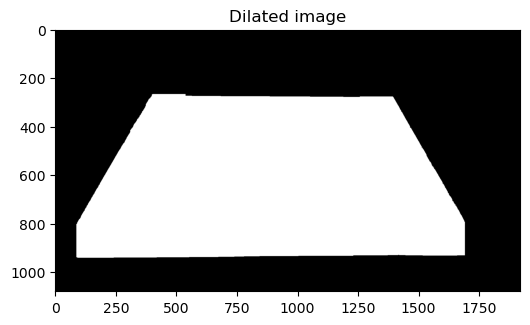

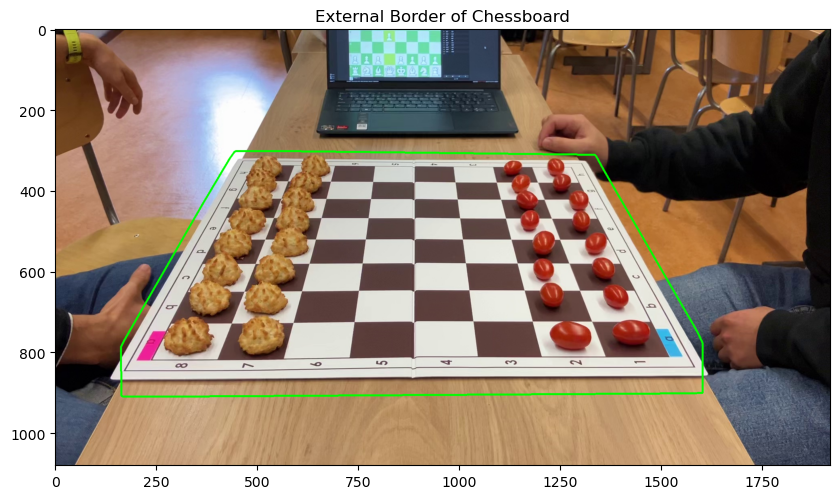

In [6]:
def external_border(frame):
    mask_white = color_mask(frame, lower_white, upper_white)

    mask_white = dilate(erode(mask_white, 2, 7), 10, 15)

    # external border of the chessboard
    edges = cv2.Canny(mask_white, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

    # Combine all contours into one
    combined_contour = np.vstack(contours).squeeze()

    # Find the convex hull of the combined contour
    hull = cv2.convexHull(combined_contour)
    
    # Shrink the hull by 10%
    center = np.mean(hull, axis=0)
    hull_shrink = (hull - center) * 0.9 + center
    hull_shrink = hull_shrink.astype(np.int32)

    return hull_shrink, combined_contour

# Define RGB color ranges for the two chessboard colors
white = [235, 236, 228]  # RGB color for the white squares
# black = [177, 129, 65]     # RGB color for the coco candy
black = [95, 64, 59]     # RGB color for the black squares
range_white = 45         # Range of color values to account for variations
range_black = 10         # Range of color values to account for variations
lower_white = [max(0, c - range_white) for c in white] # Lower bound for white color
upper_white = [min(240, c + range_white) for c in white] # Upper bound for white color
lower_black = [max(0, c - range_black) for c in black] # Lower bound for black color
upper_black = [min(240, c + range_black) for c in black] # Upper bound for black color

hull, combined_contour = external_border(img_rgb)

cv2.drawContours(img_rgb, [hull], -1, (0, 255, 0), 3)
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.title('External Border of Chessboard')
plt.show()

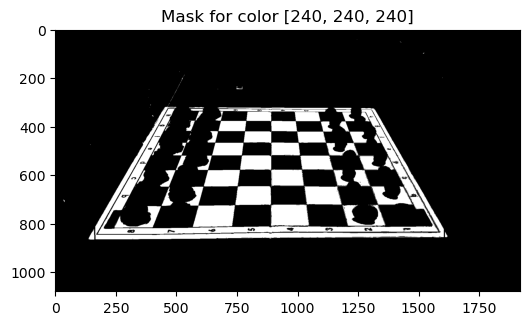

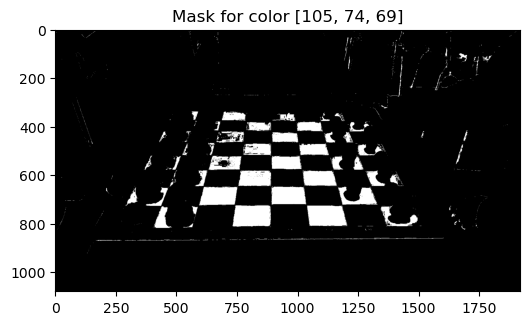

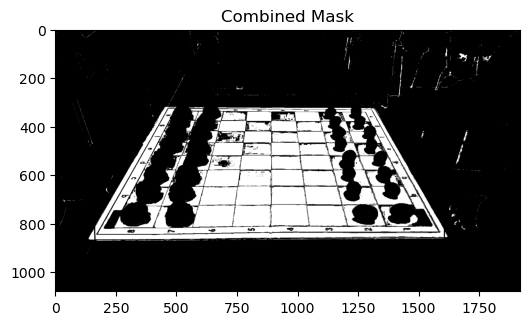

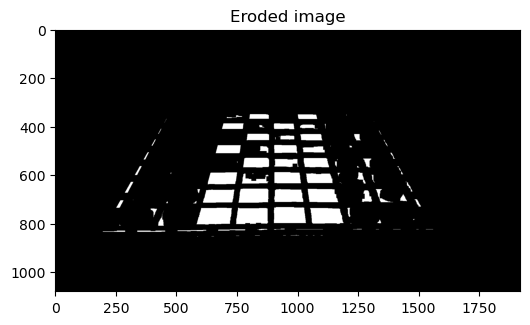

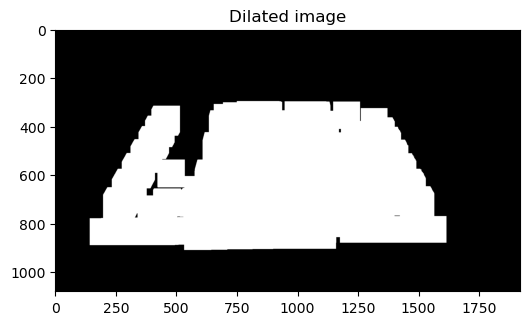

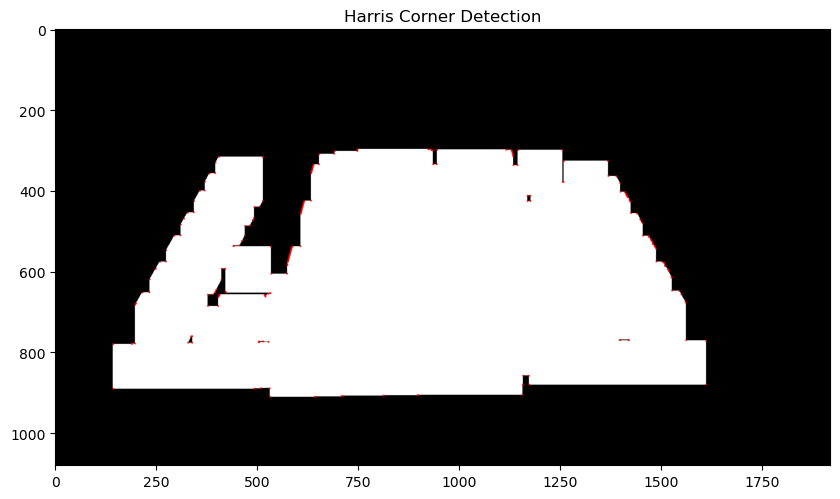

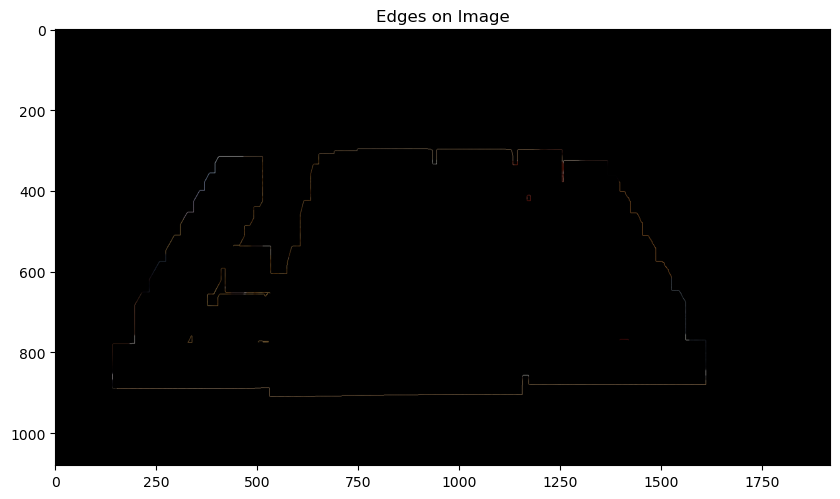

Contour 0: Area = 0.0, Perimeter = 0.0
Contour 1: Area = 1.0, Perimeter = 83.31370830535889
Contour 2: Area = 0.0, Perimeter = 47.65685415267944
Contour 3: Area = 94.0, Perimeter = 48.97056245803833
Contour 4: Area = 92.5, Perimeter = 45.55634891986847
Contour 5: Area = 9.0, Perimeter = 951.9655100107193
Contour 6: Area = 109.0, Perimeter = 41.65685415267944
Contour 7: Area = 108.5, Perimeter = 41.071067690849304
Contour 8: Area = 69.5, Perimeter = 9954.192115306854


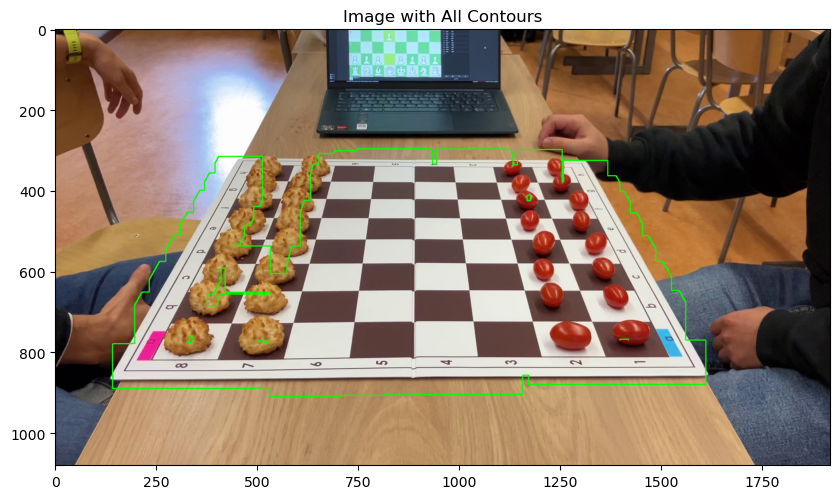

In [7]:
def harris_corner(img, block_size, ksize, k):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, block_size, ksize, k)
    dst = cv2.dilate(dst, None)
    img[dst > 0.01 * dst.max()] = [0, 0, 255]
    return img

# create masks for both the white and black squares of the chessboard
mask_white = color_mask(img_rgb, lower_white, upper_white)
# plot the mask
plt.figure(figsize=(6, 6))
plt.title(f"Mask for color {upper_white}")
plt.imshow(mask_white, cmap='gray')
plt.show()

mask_black = color_mask(img_rgb, lower_black, upper_black)
plt.figure(figsize=(6, 6))
plt.title(f"Mask for color {upper_black}")
plt.imshow(mask_black, cmap='gray')
plt.show()

# combine the masks to isolate the chessboard
combined_mask = cv2.bitwise_or(mask_white, mask_black)
plt.figure(figsize=(6, 6))
plt.title("Combined Mask")
plt.imshow(combined_mask, cmap='gray')
plt.show()

# use white_mask since capture better the chessboard
# combined_mask = mask_white

combined_mask = dilate(erode(combined_mask, 20), 110)

# apply Harris corner detection on the mask
wh_corner = cv2.cvtColor(combined_mask, cv2.COLOR_GRAY2BGR).copy()
img_harris = harris_corner(wh_corner, 2, 3, 0.04)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
plt.title('Harris Corner Detection')
plt.show()

# apply edge detection on the mask
edges = cv2.Canny(combined_mask, 50, 150)
img_edges = cv2.bitwise_and(img, img, mask=edges)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_edges, cv2.COLOR_BGR2RGB))
plt.title('Edges on Image')
plt.show()

# find contours based on the edges
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    print(f"Contour {i}: Area = {area}, Perimeter = {perimeter}")

# draw all contours on the image
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title('Image with All Contours')
plt.show()